# ApproveToolCall(Human in the loop)
Agentがツールを実行する際にユーザーの承認を求める例


## セットアップ

In [36]:
%pip install -qU langgraph==0.4.5 langchain-community langchain-openai tavily-python python-dotenv

Note: you may need to restart the kernel to use updated packages.


## 環境変数

In [37]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-study"

## 実装
- [ReAct Agent Scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)に対してHILを組み込むイメージ。

`interrupt()`を使ってユーザーに入力を求める。
- `interrupt()`(https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.interrupt)
  - ユーザーの入力を待つためにグラフを中断

- `Command`(https://langchain-ai.github.io/langgraph/concepts/low_level/#command)
  - 状態を更新すると同時に、次に実行するNodeを指定する
  - 各Nodeが`Command`オブジェクトとして以下を返す。
    - 処理を渡す先のNode
    - ステータスの更新差分

In [38]:
from typing import Annotated
from typing_extensions import TypedDict, Literal
from langchain_core.messages import AnyMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.retrievers import TavilySearchAPIRetriever

class Status(TypedDict):
    """State for the agent."""
    messages: Annotated[list[AnyMessage], add_messages]

@tool
def web_search(query: str) -> str:
   """Web検索を行うツール"""
   retriver = TavilySearchAPIRetriever(k=5) # TavilyのRetriverを定義(kは検索件数)
   search_result = retriver.invoke(query)
   return "\n\n".join(doc.page_content for doc in search_result)

tools = [web_search]
tools_by_name = {tool.name: tool for tool in tools}   # ツール名とツールのdictを作成

# モデルの定義
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
model=model.bind_tools(tools)


# Nodeの定義

# Model NOdeの定義
def model_node(state: Status):
    system_prompt = SystemMessage(
        """You are a helpful assistant. When you attempt to call an external tool and the execution of that tool is denied (either by the user or due to some other issue), you must **not** attempt to perform the task yourself. Instead, inform the user that the tool execution has failed and provide any relevant details about the failure, such as the reason for the denial (e.g., user rejection, permission issues, etc.).

Your response should include:
- A clear message that the tool execution failed.
- The reason for the failure, if available (e.g., "The user denied the request", "Permission issues", etc.).
- Do not try to execute the task on your own, as it is not allowed when the tool execution fails.
- Offer alternative actions, if possible, for the user to proceed (e.g., "Please check your permissions", "Try again later", etc.).

If the tool is successfully executed, you can proceed with your usual task of processing the result."""
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Tool Nodeの定義(tool_callに含まれるツールを実行する)
def tool_node(state: Status):
    new_messages = []
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        new_messages.append(
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
                "tool_call_id": tool_call["id"],
            }
        )
    return {"messages": new_messages}

# Human Review Nodeの定義(ユーザーの承認を求める)
def human_review_node(state: Status) -> Command[Literal["model_node", "tool_node"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    # ここでグラフを中断してユーザーの承認を求める
    human_review = interrupt(
        {
            "question": "Can I run this tool?(y/n)",
            "tool_call": tool_call,
        }
    )
    approval = human_review["approval"]

    # review_actionがYまたはyの場合はtool_nodeに遷移してツールを実行
    if approval in ['Y', 'y']:
        return Command(goto="tool_node")
    # その他の場合はToolMessageにツール実行拒否のメッセージを追加してmodel_nodeに遷移
    else:
        new_messages=[
            {
                "role": "tool",
                "name": tool_call["name"],
                "content": "Tool execution was denied by the user..",
                "tool_call_id": tool_call["id"],
            },
            # { 
            #     "role": "ai",
            #     "content": "Tool call rejected.",
            # }
        ]
        return Command(goto="model_node", update={"messages": new_messages})

# グラフの定義
workflow = StateGraph(Status)

# Nodeの追加
workflow.add_node("model_node", model_node)
workflow.add_node("tool_node", tool_node)
workflow.add_node("human_review_node", human_review_node)

# Edge関数の定義
# Model Node実行後のmessagesにtool_callが含まれているかを確認
def route_after_llm(state) -> Literal["END", "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return "END"
    else:
        return "human_review_node"

# Edgeの追加
workflow.add_edge(START, "model_node")

workflow.add_conditional_edges(
    "model_node", 
    route_after_llm,
    {
        "human_review_node": "human_review_node",
        "END": END,
    }
)
workflow.add_edge("tool_node", "model_node")

# メモリの追加
memory = MemorySaver()

# グラフのコンパイル
graph = workflow.compile(checkpointer=memory)

## グラフの描画

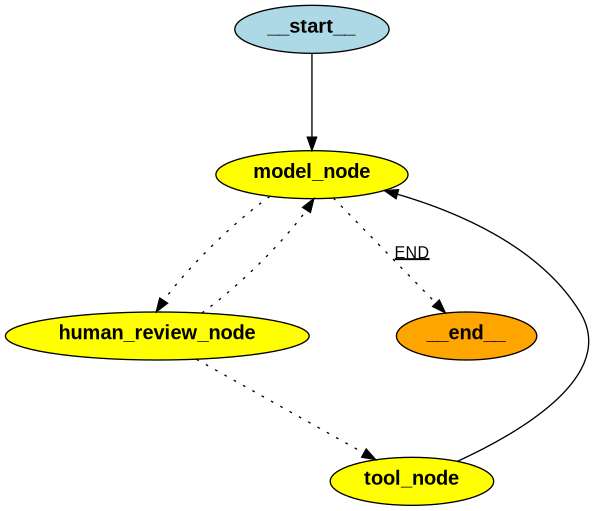

In [39]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## 実行

In [40]:
from langgraph.types import Command
import random

inputs = {"messages": [("user","静岡の郷土料理は？")]}

# Thread
num = random.randint(1, 10)
thread = {"configurable": {"thread_id": num}}

# グラフの実行
result = graph.invoke(inputs, config=thread)

# グラフがinterruptで中断されている場合はユーザーに入力を促す
while "__interrupt__" in result and result["__interrupt__"] is not None:

    # GraphInterruptインスタンスのInterruptからvalueを取得し確認メッセージを生成
    interrupt_message = result["__interrupt__"][-1].value
    confirmation_message = f'Run {interrupt_message["tool_call"]["name"]}()\n{interrupt_message["tool_call"]["args"]}\n{interrupt_message["question"]}'

    # ユーザーの標準入力への入力をhuman_review["approval"]に格納
    user_approval = input(confirmation_message)
    result = graph.invoke(Command(resume={"approval": user_approval}), config=thread)

    # print(result["messages"][-1].content)

print(result["messages"][-1].content)

静岡の郷土料理には、地域の風土や食文化を反映した多彩な料理があります。以下は代表的な郷土料理のいくつかです：

1. **黒はんぺん** - 魚のすり身を使ったはんぺんで、フライや煮物として楽しむことが多いです。
2. **とろろ汁** - 山芋をすりおろしたものを使った汁物で、さっぱりとした味わいが特徴です。
3. **金目鯛の煮付け** - 駿河湾で獲れる金目鯛を甘辛く煮付けた料理で、地元の名物です。
4. **安倍川もち** - もちをあんこやきな粉で包んだお菓子で、地元の名物として親しまれています。
5. **ところてん** - 天草から作られる寒天を使った料理で、さっぱりとした味わいが楽しめます。

静岡の郷土料理は、地元の新鮮な魚介類や野菜、わさびなどを使ったものが多く、地域の特性を生かした料理が豊富です。興味があれば、ぜひ地元の食材を使った料理を試してみてください。
